In [1]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import scipy

C:\Users\kenneth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
name = 'fashion_COGAN'
if not os.path.exists("saved_model/"+name):
        os.mkdir("saved_model/"+name)
if not os.path.exists("images/"+name):
        os.mkdir("images/"+name)

In [3]:
# Download the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('X_train', X_train.shape,'y_train', y_train.shape)
print('X_test', X_test.shape,'y_test', y_test.shape)

X_train (60000, 28, 28) y_train (60000,)
X_test (10000, 28, 28) y_test (10000,)


In [4]:
input_classes = pd.Series(y_train).nunique()
input_classes

10

In [5]:
# Training Labels are evenly distributed
Train_label_count = pd.Series(y_train).value_counts()
Train_label_count

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [6]:
# Test Labels are evenly distributed
Test_label_count = pd.Series(y_test).value_counts()
Test_label_count

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [7]:
#label dictionary from documentation
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [8]:
X_train[1].shape

(28, 28)

In [9]:
#input dimensions
input_rows = X_train[1][0]
input_cols = X_train[1][1]
input_channels = 1

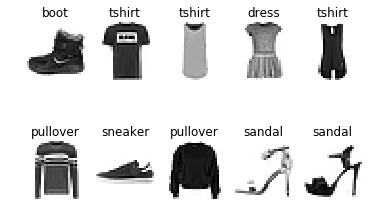

In [10]:
# plot images from the train dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i], cmap='gray_r')
    a.set_title(label_dict[y_train[i]])

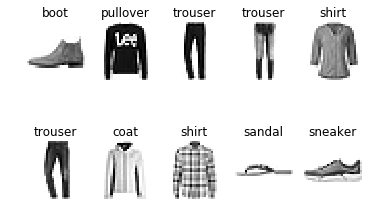

In [11]:
# plot images from the test dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_test[i], cmap='gray_r')
    a.set_title(label_dict[y_test[i]])

In [12]:
class COGAN():
    """Reference: https://wiseodd.github.io/techblog/2017/02/18/coupled_gan/"""
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.d1, self.d2 = self.build_discriminators()
        self.d1.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d2.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.g1, self.g2 = self.build_generators()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img1 = self.g1(z)
        img2 = self.g2(z)

        # For the combined model we will only train the generators
        self.d1.trainable = False
        self.d2.trainable = False

        # The valid takes generated images as input and determines validity
        valid1 = self.d1(img1)
        valid2 = self.d2(img2)

        # The combined model  (stacked generators and discriminators)
        # Trains generators to fool discriminators
        self.combined = Model(z, [valid1, valid2])
        self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
                                    optimizer=optimizer)

    def build_generators(self):

        # Shared weights between generators
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        noise = Input(shape=(self.latent_dim,))
        feature_repr = model(noise)

        # Generator 1
        g1 = Dense(1024)(feature_repr)
        g1 = LeakyReLU(alpha=0.2)(g1)
        g1 = BatchNormalization(momentum=0.8)(g1)
        g1 = Dense(np.prod(self.img_shape), activation='tanh')(g1)
        img1 = Reshape(self.img_shape)(g1)

        # Generator 2
        g2 = Dense(1024)(feature_repr)
        g2 = LeakyReLU(alpha=0.2)(g2)
        g2 = BatchNormalization(momentum=0.8)(g2)
        g2 = Dense(np.prod(self.img_shape), activation='tanh')(g2)
        img2 = Reshape(self.img_shape)(g2)

        model.summary()

        return Model(noise, img1), Model(noise, img2)

    def build_discriminators(self):

        img1 = Input(shape=self.img_shape)
        img2 = Input(shape=self.img_shape)

        # Shared discriminator layers
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))

        img1_embedding = model(img1)
        img2_embedding = model(img2)

        # Discriminator 1
        validity1 = Dense(1, activation='sigmoid')(img1_embedding)
        # Discriminator 2
        validity2 = Dense(1, activation='sigmoid')(img2_embedding)

        return Model(img1, validity1), Model(img2, validity2)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Images in domain A and B (rotated)
        X1 = X_train[:int(X_train.shape[0]/2)]
        X2 = X_train[int(X_train.shape[0]/2):]
        X2 = scipy.ndimage.interpolation.rotate(X2, 90, axes=(1, 2))

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminators
            # ----------------------

            # Select a random batch of images
            idx = np.random.randint(0, X1.shape[0], batch_size)
            imgs1 = X1[idx]
            imgs2 = X2[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a batch of new images
            gen_imgs1 = self.g1.predict(noise)
            gen_imgs2 = self.g2.predict(noise)

            # Train the discriminators
            d1_loss_real = self.d1.train_on_batch(imgs1, valid)
            d2_loss_real = self.d2.train_on_batch(imgs2, valid)
            d1_loss_fake = self.d1.train_on_batch(gen_imgs1, fake)
            d2_loss_fake = self.d2.train_on_batch(gen_imgs2, fake)
            d1_loss = 0.5 * np.add(d1_loss_real, d1_loss_fake)
            d2_loss = 0.5 * np.add(d2_loss_real, d2_loss_fake)


            # ------------------
            #  Train Generators
            # ------------------

            g_loss = self.combined.train_on_batch(noise, [valid, valid])

            # Plot the progress
#             print ("%d [D1 loss: %f, acc.: %.2f%%] [D2 loss: %f, acc.: %.2f%%] [G loss: %f]" \
#                 % (epoch, d1_loss[0], 100*d1_loss[1], d2_loss[0], 100*d2_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                self.save_model()
                print ("%d [D1 loss: %f, acc.: %.2f%%] [D2 loss: %f, acc.: %.2f%%] [G loss: %f]" \
                % (epoch, d1_loss[0], 100*d1_loss[1], d2_loss[0], 100*d2_loss[1], g_loss[0]))

    def sample_images(self, epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * int(c/2), 100))
        gen_imgs1 = self.g1.predict(noise)
        gen_imgs2 = self.g2.predict(noise)

        gen_imgs = np.concatenate([gen_imgs1, gen_imgs2])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/"+name+"/_%d.png" % epoch)
        plt.imread("images/"+name+"/_%d.png" % epoch)
        plt.show()
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/"+name+"/%s.json" % model_name
            weights_path = "saved_model/"+name+"/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])
        save(self.g1, "cogan_generator1")
        save(self.g2, "cogan_generator2")
        save(self.d1, "cogan_discriminator1")
        save(self.d2, "cogan_discriminator2")
        save(self.combined, "cogan_combined")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
Total params: 160,512
Trainable params: 158,976
Non-trainable params: 1,536
_________________________________________________________________


C:\Users\kenneth\Anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


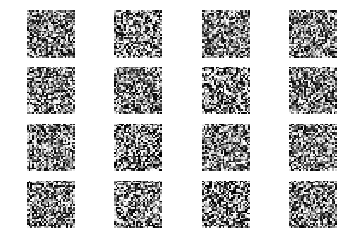

0 [D1 loss: 0.748991, acc.: 48.44%] [D2 loss: 0.686489, acc.: 59.38%] [G loss: 1.646095]


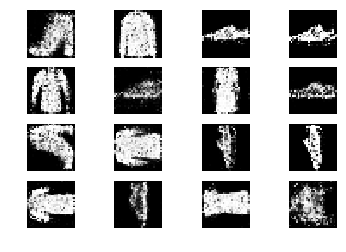

10000 [D1 loss: 0.671167, acc.: 57.81%] [D2 loss: 0.635759, acc.: 75.00%] [G loss: 1.811553]


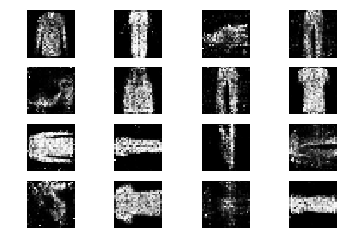

20000 [D1 loss: 0.677182, acc.: 62.50%] [D2 loss: 0.656843, acc.: 60.94%] [G loss: 1.878872]


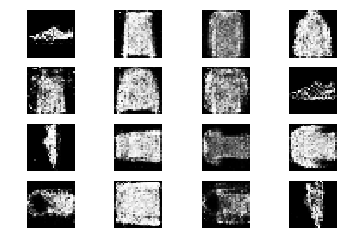

30000 [D1 loss: 0.588883, acc.: 75.00%] [D2 loss: 0.648151, acc.: 57.81%] [G loss: 1.918404]


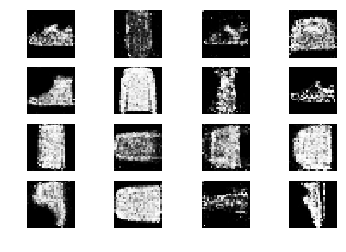

40000 [D1 loss: 0.618814, acc.: 68.75%] [D2 loss: 0.716632, acc.: 51.56%] [G loss: 1.938732]


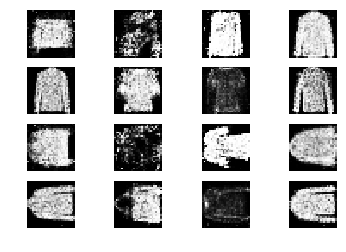

50000 [D1 loss: 0.601488, acc.: 65.62%] [D2 loss: 0.620392, acc.: 65.62%] [G loss: 2.042117]


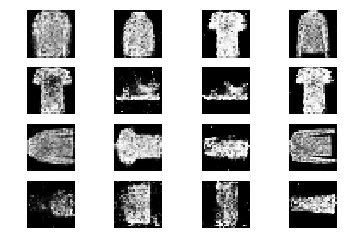

60000 [D1 loss: 0.681767, acc.: 57.81%] [D2 loss: 0.574250, acc.: 67.19%] [G loss: 2.062700]


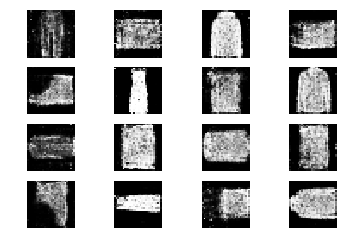

70000 [D1 loss: 0.608536, acc.: 67.19%] [D2 loss: 0.572797, acc.: 65.62%] [G loss: 2.294270]


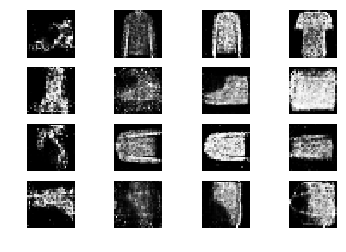

80000 [D1 loss: 0.692322, acc.: 57.81%] [D2 loss: 0.648174, acc.: 62.50%] [G loss: 2.521599]


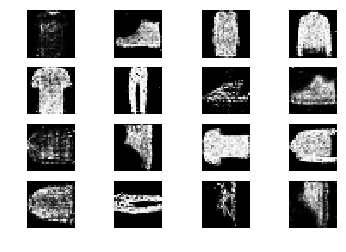

90000 [D1 loss: 0.566025, acc.: 73.44%] [D2 loss: 0.695410, acc.: 53.12%] [G loss: 2.724525]


In [13]:
gan = COGAN()
gan.train(epochs=100000, batch_size=32, sample_interval=10000)
